<a id="1"></a> <br>
# <center><span style="font-family:cursive;">If you liked my work then please upvote, Thank you.</span></center>

# Contents

* [Import Libraries and the Data](#1)
* [Data Preprocessing](#2)
    - [Pandas Profiling](#21)
    - [Label Encoding](#23)
    - [Choosing The Features and The Label, and Train-Test Split](#24)
    - [Min-Max Normalization](#22)
* [Data Prediction](#3)
    - [Logistic Regression](#31)
    - [Support Vector Machine (Support Vector Classifier)](#32)
    - [Random Forest Classifier](#33)
    - [Max Voting](#34)
* [Results](#4)
    - [Model Scores](#41)
    - [Bias-Variance Tradeoff](#42)
    - [Best Model Evaluation](#43)


<a id="1"></a> <br>
# <center><span style="font-family:cursive;">Import Libraries and the Data</span></center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import MinMaxScaler
from pandas_profiling import ProfileReport
import seaborn as sns
from scipy.stats import beta
from scipy.stats import f

In [2]:
data = pd.read_csv('/kaggle/input/early-diabetes-classification/diabetes_data.csv', sep=';')

<a id="2"></a> <br>
# <center><span style="font-family:cursive;">Data Preprocessing</span></center>

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   age                 520 non-null    int64 
 1   gender              520 non-null    object
 2   polyuria            520 non-null    int64 
 3   polydipsia          520 non-null    int64 
 4   sudden_weight_loss  520 non-null    int64 
 5   weakness            520 non-null    int64 
 6   polyphagia          520 non-null    int64 
 7   genital_thrush      520 non-null    int64 
 8   visual_blurring     520 non-null    int64 
 9   itching             520 non-null    int64 
 10  irritability        520 non-null    int64 
 11  delayed_healing     520 non-null    int64 
 12  partial_paresis     520 non-null    int64 
 13  muscle_stiffness    520 non-null    int64 
 14  alopecia            520 non-null    int64 
 15  obesity             520 non-null    int64 
 16  class               520 no

In [4]:
data.head()

age gender  polyuria  polydipsia  sudden_weight_loss  weakness  polyphagia  \
0   40   Male         0           1                   0         1           0   
1   58   Male         0           0                   0         1           0   
2   41   Male         1           0                   0         1           1   
3   45   Male         0           0                   1         1           1   
4   60   Male         1           1                   1         1           1   

   genital_thrush  visual_blurring  itching  irritability  delayed_healing  \
0               0                0        1             0                1   
1               0                1        0             0                0   
2               0                0        1             0                1   
3               1                0        1             0                1   
4               0                1        1             1                1   

   partial_paresis  muscle_stiffness  alopecia  obesity  class  
0                0                 1         1        1      1  
1                1                 0         1        0      1  
2                0                 1         1        0      1  
3                0                 0         0        0      1  
4                1                 1         1        1      1

We can also benefit from using Pandas Profiling as well. It is an amazing tool that can generate thorough profile reports and interesting plots for EDA and descriptive analysis purposes. Here are some of the observations from this profile report:

1. we have 17 variables or features and 520 observations.
2. all of the features except age are categorical.
3. There are some duplicates in the dataset. Meaning that some rows have the same values for different features. Since most of the features are categorical and binary, I expected to have some duplicates but, it's interesting to take a look at the most frequently occurred duplicates too.
4. The skewness of the age variable is 0.329 (click on toggle details in Variables part and age). Meaning that age has a right-skewed distribution. 
5. Using the calculated IQR we can compute the Lower Whisker (LW) and Upper Whisker (WH), and detect the outliers afterward. Even before using such a method, I'm pretty sure that there are some outliers in the data by looking at the age histogram or age extreme values. These outliers might even be responsible for the right-skewed age distribution. However, only 1% of the observations are suspicious of being outliers. Therefore, I'm going to neglect them here, and do not remove them. For more information on outlier handling, you can take a look at [this notebook of mine](https://www.kaggle.com/kamyarazar/breast-cancer-classification-using-pca-in-python).
6. We can see that other features are binary. Most of them are evenly distributed, meaning that we have close numbers of 0 and 1, except gender, genital_thrush, irritability, muscle_stiffness, and obesity. if you want to take a look at the pie chart of these variables, you can find it in Variables -> Toggle details -> Categories.
7. Another important thing to always take a look at in healthcare-related data is the sparsity in the data. Again lets take a look at the pie chart of the class feature: 1 -> 320 -> 61.5% ||| 0 -> 200 -> 38.5%. As it's obvious sparsity is not a problem here, and we have enough 0 and 1 observations.
8. The correlations between the features are mostly positive. There is a strong correlation between class, polyuria, and polydipsia.
9. You can also take a look at the last table, Duplicate Rows, most frequently occurring. Since I don't have more information on the observations, like the name, observation time, ID, etc., I can't say if these are really duplicates, or either they were different people or the same person at different times. Hence, I'll have to leave them like that.

<a id="21"></a> <br>
## Pandas Profiling

In [5]:
# pandas profiling
profile = ProfileReport(data)
profile

Summarize dataset:   0%|          | 0/30 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

So, after all, there are two things needed to be done in the data preprocessing phase.
1. Scaling the Age feature
2. Enoding the Gender

For scaling, I'm going to use MinMaxScaler but you can use StandardScaler as well. Also, for encoding the Age feature, I'll use LabelEncoder provided in the Scikt-learn library.

<a id="23"></a> <br>
## Label Encoding

In [6]:
# Encoding
label_encoder = LabelEncoder() 
data['gender'] = label_encoder.fit_transform(data['gender'])

data.head(10)

age  gender  polyuria  polydipsia  sudden_weight_loss  weakness  \
0   40       1         0           1                   0         1   
1   58       1         0           0                   0         1   
2   41       1         1           0                   0         1   
3   45       1         0           0                   1         1   
4   60       1         1           1                   1         1   
5   55       1         1           1                   0         1   
6   57       1         1           1                   0         1   
7   66       1         1           1                   1         1   
8   67       1         1           1                   0         1   
9   70       1         0           1                   1         1   

   polyphagia  genital_thrush  visual_blurring  itching  irritability  \
0           0               0                0        1             0   
1           0               0                1        0             0   
2           1               0                0        1             0   
3           1               1                0        1             0   
4           1               0                1        1             1   
5           1               0                1        1             0   
6           1               1                0        0             0   
7           0               0                1        1             1   
8           1               1                0        1             1   
9           1               0                1        1             1   

   delayed_healing  partial_paresis  muscle_stiffness  alopecia  obesity  \
0                1                0                 1         1        1   
1                0                1                 0         1        0   
2                1                0                 1         1        0   
3                1                0                 0         0        0   
4                1                1                 1         1        1   
5                1                0                 1         1        1   
6                1                1                 0         0        0   
7                0                1                 1         0        0   
8                0                1                 1         0        1   
9                0                0                 0         1        0   

   class  
0      1  
1      1  
2      1  
3      1  
4      1  
5      1  
6      1  
7      1  
8      1  
9      1

<a id="24"></a> <br>
## Choosing The Features and The Label, and Train-Test Split

In [7]:
# Choosing the features and the label
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

print(X.shape)
print(X.iloc[:5, :])
print('\n')
print(y.shape)
print(y[:5])

(520, 16)
   age  gender  polyuria  polydipsia  sudden_weight_loss  weakness  \
0   40       1         0           1                   0         1   
1   58       1         0           0                   0         1   
2   41       1         1           0                   0         1   
3   45       1         0           0                   1         1   
4   60       1         1           1                   1         1   

   polyphagia  genital_thrush  visual_blurring  itching  irritability  \
0           0               0                0        1             0   
1           0               0                1        0             0   
2           1               0                0        1             0   
3           1               1                0        1             0   
4           1               0                1        1             1   

   delayed_healing  partial_paresis  muscle_stiffness  alopecia  obesity  
0                1                0                 1  

In [8]:
# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(y_train.shape)
print('\n')
print(X_test.shape)
print(y_test.shape)

(416, 16)
(416,)


(104, 16)
(104,)


<a id="22"></a> <br>
## Min-Max Normalization

In [9]:
# Scaling
encoder = MinMaxScaler()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

pd.DataFrame(X_train, columns = X.columns)

age  gender  polyuria  polydipsia  sudden_weight_loss  weakness  \
0    0.148649     1.0       0.0         0.0                 0.0       0.0   
1    0.418919     1.0       0.0         0.0                 0.0       0.0   
2    0.675676     0.0       1.0         1.0                 1.0       1.0   
3    0.418919     1.0       0.0         0.0                 0.0       0.0   
4    0.662162     0.0       1.0         1.0                 0.0       1.0   
..        ...     ...       ...         ...                 ...       ...   
411  0.324324     0.0       0.0         0.0                 1.0       1.0   
412  0.148649     1.0       0.0         0.0                 0.0       0.0   
413  0.729730     1.0       0.0         1.0                 1.0       1.0   
414  0.432432     1.0       1.0         1.0                 1.0       0.0   
415  0.648649     1.0       0.0         1.0                 0.0       0.0   

     polyphagia  genital_thrush  visual_blurring  itching  irritability  \
0           0.0             0.0              0.0      0.0           0.0   
1           0.0             0.0              0.0      0.0           1.0   
2           1.0             1.0              1.0      1.0           0.0   
3           0.0             0.0              0.0      1.0           0.0   
4           1.0             0.0              0.0      1.0           0.0   
..          ...             ...              ...      ...           ...   
411         0.0             0.0              0.0      0.0           0.0   
412         0.0             0.0              0.0      0.0           0.0   
413         1.0             0.0              1.0      1.0           1.0   
414         1.0             1.0              0.0      0.0           0.0   
415         0.0             0.0              0.0      0.0           1.0   

     delayed_healing  partial_paresis  muscle_stiffness  alopecia  obesity  
0                0.0              0.0               0.0       0.0      0.0  
1                0.0              1.0               0.0       0.0      1.0  
2                1.0              1.0               1.0       0.0      0.0  
3                0.0              0.0               0.0       1.0      0.0  
4                0.0              1.0               1.0       0.0      0.0  
..               ...              ...               ...       ...      ...  
411              0.0              0.0               0.0       0.0      0.0  
412              0.0              0.0               0.0       0.0      0.0  
413              0.0              0.0               0.0       1.0      0.0  
414              1.0              0.0               0.0       0.0      0.0  
415              1.0              0.0               0.0       0.0      0.0  

[416 rows x 16 columns]

<a id="3"></a> <br>
# <center><span style="font-family:cursive;">Data Prediction</span></center>

Now, data preprocessing is done, and we can go for the next part that is training prediction models. Here, we used Logistic Regression, SVM, and two ensemble learning methods known as Random Forest and Max Voting. To get a relevant measure of bias and variance and compare different models more reliably, we have applied K-fold Cross-Validation for each model as well. It is worthy to note that each model's hyperparameters need to be tuned, but here, we have done hyperparameter tuning just for Random Forest and SVM. To tune the Random Forest hyperparameter, we tried different values for the number of trees in the forest between [1, 50], and choose the value which has the highest 10-fold Cross-Validated accuracy score. Also, for tuning SVM's hyperparameter, we have tried different configurations of the hyperparameters to get the best result.

The results of the different models will be saved in a variable called *Model_Score* to compare at the end.

<a id="31"></a> <br>
## Logistic Regression

In [10]:
Model_Score = []

# Logistic Regression
classifier_lr = LogisticRegression(random_state=0)
scores = cross_val_score(classifier_lr, X_train, y_train, cv=10, scoring='accuracy')
lr_train_score_mean = scores.mean()
lr_train_score_std = scores.std()
classifier_lr.fit(X_train, y_train)
model_name = 'Logistic Regression'
lr_test_score = classifier_lr.score(X_test, y_test)

score = list((model_name, lr_train_score_mean.round(4), lr_train_score_std.round(4), lr_test_score.round(4)))
Model_Score.append(score)

<a id="32"></a> <br>
## Support Vector Machine (Support Vector Classifier)

In [11]:
# SVC
def svm(degree, kernel, gamma, x_train, x_test, train_label, test_label):
    if kernel == 'poly':
        support_vector_machine = SVC(kernel='poly', degree=degree, random_state=0)
        cv_score = cross_val_score(support_vector_machine, x_train, train_label, cv=10)
        svm_train_score_mean = cv_score.mean()
        svm_train_score_std = cv_score.std()
        support_vector_machine.fit(x_train, train_label)
        svm_test_score = support_vector_machine.score(x_test, test_label)
        name = 'SVM with ' + str(degree) + '-degree polynomial kernel'
    elif kernel == 'rbf':
        support_vector_machine = SVC(kernel='rbf', gamma=gamma, random_state=0)
        cv_score = cross_val_score(support_vector_machine, x_train, train_label, cv=10)
        svm_train_score_mean = cv_score.mean()
        svm_train_score_std = cv_score.std()
        support_vector_machine.fit(x_train, train_label)
        svm_test_score = support_vector_machine.score(x_test, test_label)
        name = 'SVM with rbf kernel and ' + str(gamma) + ' coefficient'
    else:
        support_vector_machine = SVC(kernel='sigmoid', gamma=gamma, random_state=0)
        cv_score = cross_val_score(support_vector_machine, x_train, train_label, cv=10)
        svm_train_score_mean = cv_score.mean()
        svm_train_score_std = cv_score.std()
        support_vector_machine.fit(x_train, train_label)
        svm_test_score = support_vector_machine.score(x_test, test_label)
        name = 'SVM with sigmoid kernel and ' + str(gamma) + ' coefficient'
    return support_vector_machine, list((name, svm_train_score_mean.round(4), svm_train_score_std.round(4),
                                         svm_test_score.round(4)))

svc_models = [
    [None, 'rbf', 'scale'], [None, 'rbf', 'auto'], [None, 'sigmoid', 'scale'], [None, 'sigmoid', 'auto'],
    [1, 'poly', None], [2, 'poly', None], [3, 'poly', 'None'], [4, 'poly', 'None'], [5, 'poly', 'None']
]

for i, x in enumerate(svc_models):
    _, score = svm(svc_models[i][0], svc_models[i][1], svc_models[i][2], X_train, X_test, y_train, y_test)
    Model_Score.append(score)

<a id="33"></a> <br>
## Random Forest Classifier

In [12]:
# Random Forest Classification
acc_score = []
std_score = []
max_rf_ne = 50
for ne in range(1, max_rf_ne):
    classifier_rf = RandomForestClassifier(n_estimators=ne, random_state=0)
    scores = cross_val_score(classifier_rf, X_train, y_train, cv=10, scoring='accuracy')
    rf_train_score_mean = scores.mean()
    rf_train_score_std = scores.std()
    acc_score.append(rf_train_score_mean)
    std_score.append(rf_train_score_std)

best_rf_acc = max(acc_score)
best_rf_ne = acc_score.index(max(acc_score))

classifier_rf = RandomForestClassifier(n_estimators=best_rf_ne, random_state=0)
classifier_rf.fit(X_train, y_train)
rf_test_score = classifier_rf.score(X_test, y_test)

model_name = 'Random Forest with ' + str(best_rf_ne) + ' estimators'

score = list((model_name, rf_train_score_mean.round(4), rf_train_score_std.round(4), rf_test_score.round(4)))
Model_Score.append(score)

Here are the model accuracies for different numbers of trees in the forest.

Text(0.5, 1.0, 'accuracy/# of trees')

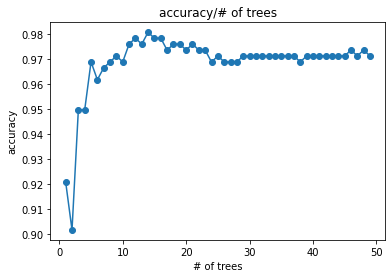

In [13]:
f, ax = plt.subplots()
ax.plot(range(1, max_rf_ne), acc_score, marker='o')
ax.set_xlabel('# of trees')
ax.set_ylabel('accuracy')
ax.set_title('accuracy/# of trees')

<a id="34"></a> <br>
## Max Voting

In [14]:
# Max voting
def max_voting(estimators, x_train, x_test, train_label, test_label):
    mv_classifier = VotingClassifier(estimators=estimators, voting='hard')
    cv_score = cross_val_score(mv_classifier, x_train, train_label, cv=10)
    mv_train_score_mean = cv_score.mean()
    mv_train_score_std = cv_score.std()
    mv_classifier.fit(x_train, train_label)
    name = 'Max voting'  # Add the name of the base models (estimators)
    mv_test_score = mv_classifier.score(x_test, test_label)
    return mv_classifier, list((name, mv_train_score_mean.round(4), mv_train_score_std.round(4),
                                mv_test_score.round(4)))

model_1 = RandomForestClassifier(n_estimators=best_rf_ne)
model_2 = LogisticRegression(random_state=0)
model_3 = SVC(kernel='poly', degree=2)
model_4 = SVC(kernel='poly', degree=3)
model_5 = SVC(kernel='poly', degree=4)
model_6 = SVC(kernel='poly', degree=5)
model_7 = SVC(kernel='rbf', gamma='scale')
model_8 = SVC(kernel='rbf', gamma='auto')
model_9 = SVC(kernel='sigmoid', gamma='scale')
model_10 = SVC(kernel='sigmoid', gamma='auto')

# version 10
classifier_mv, score = max_voting([('rf', model_1), ('lr', model_2), ('SVM_2', model_3), ('SVM_3', model_4),
                                   ('SVM_4', model_5), ('SVM_5', model_6), ('SVM_rbf_scale', model_7),
                                   ('SVM_rbf_auto', model_8), ('SVM_sigmoid_scale', model_9),
                                   ('SVM_sigmoid_auto', model_10)], X_train, X_test, y_train, y_test)

Model_Score.append(score)

<a id="4"></a> <br>
# <center><span style="font-family:cursive;">Results</span></center>

<a id="41"></a> <br>
## Model Scores

In [15]:
# Results
Model_Score = pd.DataFrame(Model_Score, columns=['Model', 'Train Score Average', 'Train Score SD', 'Test Score'])
Model_Score = Model_Score.sort_values(by=['Test Score'], ascending=False)

In [16]:
Model_Score

Model  Train Score Average  \
1       SVM with rbf kernel and scale coefficient               0.9545   
7             SVM with 3-degree polynomial kernel               0.9400   
10               Random Forest with 13 estimators               0.9713   
6             SVM with 2-degree polynomial kernel               0.9208   
8             SVM with 4-degree polynomial kernel               0.9400   
9             SVM with 5-degree polynomial kernel               0.9351   
11                                     Max voting               0.9401   
2        SVM with rbf kernel and auto coefficient               0.9208   
0                             Logistic Regression               0.9184   
4    SVM with sigmoid kernel and auto coefficient               0.8823   
5             SVM with 1-degree polynomial kernel               0.9231   
3   SVM with sigmoid kernel and scale coefficient               0.7841   

    Train Score SD  Test Score  
1           0.0445      1.0000  
7           0.0358      0.9904  
10          0.0297      0.9904  
6           0.0397      0.9808  
8           0.0325      0.9808  
9           0.0402      0.9808  
11          0.0373      0.9808  
2           0.0411      0.9615  
0           0.0400      0.9519  
4           0.0507      0.9519  
5           0.0396      0.9519  
3           0.0704      0.8269

<a id="42"></a> <br>
## Bias-Variance Tradeoff

Pay attention! As you can see we got 100% accuracy on the test set using SVM with rbf kernel and scale coefficient. However, we should always be more careful with 100% test accuracy. That's where Cross-Validation techniques like K-fold CV come in handy. As the result of the K-fold CV suggest, the mean of the cross-validated results is 0.9545 with an SD of 0.0445. The high variance of K-fold cross-validation means that the model is not robust enough, and if we run the model again, we may get different and even worse results. Also, if we use the model to make predictions on new observations that the model has not seen yet, we may not get good results. To better understand this concept, take a look at the below two pictures. We are looking for a model with no or low bias and low variability.

![](https://community.alteryx.com/t5/image/serverpage/image-id/52874iE986B6E19F3248CF/image-size/large?v=v2&px=999)

![](https://miro.medium.com/max/1400/1*9hPX9pAO3jqLrzt0IE3JzA.png)

With that in mind, I chose the Random Forest with 13 estimators as our final model.

<a id="43"></a> <br>
## Best Model Evaluation

In a classification problem, especially when it's used in the healthcare area, accuracy might not be the best metric to evaluate the performance of the model. For example, in healthcare, the false negatives (negative outcomes that the model predicted incorrectly) might be more important than the false positives (positive outcomes that the model predicted incorrectly). Why so? Consider these two scenarios:

1. False negatives: if someone has diabetes, but our model predicted that he doesn't have (predicted incorrectly).
2. False positives: if someone doesn't have diabetes, but our model predicted that he has (predicted incorrectly).

Obviously, the first scenario is far more dangerous than the second one. In the second case, by doing more experiments, we can finally understand that the patient doesn't have diabetes. The consequences might be only financial (hope this guy has insurance! :)). However, in the other case, we are sending this patient home because we think he doesn't have diabetes and he may come back again in the future when his illness is worse than before. Take a look at the below two pictures as well. I hope you got the idea! So let's take a look at the confusion matrix and other metrics like precision, recall, and f1-score. A detailed explanation on these metrics can be found [here](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/).

![](https://miro.medium.com/max/559/1*PuhUdkH2tKomTEYDRL1PwQ.png)
![](https://miro.medium.com/max/700/1*jYoVGvwPH0qt2M7Xq24jTQ.png)

In [17]:
y_pred = classifier_rf.predict(X_test)
labels = target_names = ['Class 0', 'Class 1']
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

     Class 0       0.98      1.00      0.99        40
     Class 1       1.00      0.98      0.99        64

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104



In [18]:
# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred)

print(cm_lr)

[[40  0]
 [ 1 63]]


**Perfect!**

<a id="1"></a> <br>
# <center><span style="font-family:cursive;">If you liked my work then please upvote, Thank you.</span></center>